In [1]:
import pandas as pd
import json
from IPython.display import display
import os
import numpy as np

In [20]:
def load_data_to_df(filepath):
    with open(filepath, 'rb') as f:
        res = json.load(f)
    res = res['results']

    df = pd.concat([pd.DataFrame(r) for r in res], axis=0, keys=range(len(res)))
    df = pd.concat([df, df['hyperparam'].apply(pd.Series)], axis=1).drop(columns='hyperparam')
    df = df.rename_axis(['rollout', 'config_id'], axis='index')
    return df


def select_hparams(df, hparam_config):
    # Select results for specific hparams
    if hparam_config:
        for key, val in hparam_config.items():
            if not isinstance(val, list):
                val = [val]
            df = df[df[key].isin(val)]
    return df


# Best hparam configs
def get_best_hparam_results(df, metric='val_loss', num_best=10000, hparam_config=None):
    if hparam_config:
        df = select_hparams(df, hparam_config)

    best = df.groupby('config_id').mean().sort_values(by=metric)[:num_best]
    return best


def get_mean_and_sem(df, test_metric='test_risk', val_metric='val_loss', hparam_config=None):
    if df.reset_index()['config_id'].nunique() > 1:
        best = get_best_hparam_results(df, metric=val_metric, num_best=1, hparam_config=hparam_config).reset_index()
        best_config_id = best.loc[0].config_id
    else:
        best_config_id = 0

    df = df.reset_index()
    df = df[df["config_id"]==best_config_id]
    return df[test_metric].mean(), df[test_metric].sem()

In [3]:
# Merge datasets
def load_and_merge_datasets(filepaths=None, property_dict=None, merge='hparam_configs', load_all_in_dir=None, method=None):
    assert (load_all_in_dir and method) or (load_all_in_dir is None and method is None)
    
    if isinstance(filepaths, str):
        filepaths = [filepaths]
    elif filepaths is None and load_all_in_dir:
        filelist = os.listdir(load_all_in_dir)
        filepaths = []
        for fp in filelist:
            if method in fp:
                filepaths.append(load_all_in_dir + fp)
        
    if merge == 'rollouts':
        merge_property = 'rollout'
    elif merge == 'hparam_configs':
        merge_property = 'config_id'
    else:
        raise NotImplementedError
    
    if not property_dict:
        prop_name = 'version'
        vals = range(len(filepaths))
    else:
        prop_name = list(property_dict.keys())[0]
        vals = property_dict[prop_name]
        
    start_merge_id = 0
    dfs = []
                
    successful = 0
    for filepath, prop in zip(filepaths, vals):
        try:
            data_frame = load_data_to_df(filepath)
            data_frame = data_frame.drop(columns=['test_risk_optim', 'parameter_mse_optim', 'best_index'])
            data_frame[prop_name] = prop

            # Add new config id
            data_frame = data_frame.reset_index()
            data_frame[merge_property] += start_merge_id
            start_merge_id = data_frame[merge_property].max() + 1
            dfs.append(data_frame)
            successful += 1
        except FileNotFoundError:
            pass
            # print('File not found:', filepath)
    print(f'Found {successful}/{len(filepaths)} files.')

    df = pd.concat(dfs, ignore_index=True)
    df = df.set_index(['rollout', 'config_id'])
    return df

filepath1 = '../results/bennet_hetero/bennet_hetero_method=KMM-RF_n=2000.json'
filepath2 = '../results/bennet_hetero/bennet_hetero_method=KMM-RF_n=2000.json'
fps = [filepath1, filepath2]
property_dict = {'divergence': ['kl', 'log']}

df1 = load_data_to_df(filepath1)
df2 = load_data_to_df(filepath2)
df3 = load_and_merge_datasets(fps, property_dict)

print(get_mean_and_sem(df1))
print(get_mean_and_sem(df2))
print(get_mean_and_sem(df3))

best = get_best_hparam_results(df3, metric='test_risk')
best

df = load_and_merge_datasets('../results/bennet_hetero/bennet_hetero_method=KMM-RF_n=2000.json')
best = get_best_hparam_results(df, metric='test_risk', num_best=20)
best

# EXP1: Bennett Hetero

In [4]:
exp_path_1 = "/Users/hkremer/code/kmm/wasserstein-method-of-moments/results/bennet_hetero/bennet_hetero_method="

## VMM

In [5]:
vmm = load_and_merge_datasets(exp_path_1 + "VMM-neural_n=2000_seed0=12345.json")
best_vmm = get_best_hparam_results(vmm, metric='val_loss',)
best_vmm

Found 1/1 files.


,test_risk,mse,val_loss,reg_param,version
config_id,,,,,
3,0.270553,0.253146,0.819964,1.0000,0.0
2,0.239885,0.167199,0.826770,0.0100,0.0
0,0.226658,0.150483,0.828801,0.0000,0.0
1,0.235654,0.188516,0.828997,0.0001,0.0


## FGEL

In [6]:
fgel = load_and_merge_datasets(load_all_in_dir='/Users/hkremer/code/kmm/wasserstein-method-of-moments/results/bennet_hetero/',
                               method='FGEL-neural')
best_fgel = get_best_hparam_results(fgel, metric='val_loss', hparam_config={'divergence': 'log',
                                                                           'val_loss_func': np.nan})
best_fgel

Found 9/9 files.


,test_risk,mse,val_loss,reg_param,version
config_id,,,,,
19,0.187290,0.167554,0.832788,1.0000,8.0
16,0.448142,0.796722,0.908296,0.0100,8.0
10,0.473520,0.859253,0.909634,0.0000,8.0
13,0.498310,0.890296,0.918164,0.0001,8.0


In [7]:
fgel = load_and_merge_datasets(exp_path_1 + "FGEL-neural_n=2000_seed0=12345.json")
best_fgel = get_best_hparam_results(fgel, metric='val_loss', hparam_config={'divergence': 'log'})
best_fgel

Found 1/1 files.


,test_risk,mse,val_loss,reg_param,version
config_id,,,,,
11,0.187290,0.167554,0.832788,1.0000,0.0
8,0.448142,0.796722,0.908296,0.0100,0.0
2,0.473520,0.859253,0.909634,0.0000,0.0
5,0.498310,0.890296,0.918164,0.0001,0.0


## KMM

In [8]:
filepaths = []

# from cmr.default_config import kmm_methods

# for method in kmm_methods:
#     path = (exp_path_1 + f'{method}_n=2000_seed0=12345.json')
#     filepaths.append(path)
    
# df = load_and_merge_datasets(filepaths)

kmm = load_and_merge_datasets(load_all_in_dir='/Users/hkremer/code/kmm/wasserstein-method-of-moments/results/bennet_hetero/',
                              method='KMM')
get_best_hparam_results(kmm, metric='val_loss', hparam_config={
                                                            #'divergence': 'log', 
                                                           'val_loss_func': 'moment_violation'
})

Found 1083/1083 files.


,test_risk,mse,val_loss,n_reference_samples,entropy_reg_param,reg_param,kde_bw,version,rkhs_reg_param
config_id,,,,,,,,,
426,0.335088,0.306584,0.814350,0.0,1000.0,1.0000,0.1,426.0,NaN
457,0.302836,0.280674,0.814999,0.0,10.0,1.0000,0.5,457.0,NaN
170,0.302836,0.280674,0.814999,0.0,10.0,1.0000,0.1,170.0,NaN
348,0.291244,0.211149,0.815597,0.0,100.0,1.0000,0.1,348.0,NaN
380,0.291244,0.211149,0.815597,0.0,100.0,1.0000,0.5,380.0,NaN
...,...,...,...,...,...,...,...,...,...
664,1.137004,1.347585,0.990399,0.0,1.0,0.0001,0.1,664.0,NaN
728,1.408171,1.410041,0.990414,0.0,1.0,0.0000,0.5,728.0,NaN
1051,2.482570,1.161349,1.041876,0.0,1.0,0.0001,0.1,1051.0,NaN


In [9]:
get_best_hparam_results(kmm, metric='val_loss', num_best=20, 
                        hparam_config={'val_loss_func': 'moment_violation',
                                       #"n_reference_samples": [200], 
                                       "entropy_reg_param": [1000],
                                       #"reg_param": [0.01],
                                       'kde_bw': 0.1,
                                      })

,test_risk,mse,val_loss,n_reference_samples,entropy_reg_param,reg_param,kde_bw,version,rkhs_reg_param
config_id,,,,,,,,,
426,0.335088,0.306584,0.814350,0.0,1000.0,1.00,0.1,426.0,NaN
972,0.277269,0.224168,0.817010,0.0,1000.0,1.00,0.1,972.0,NaN
246,0.271406,0.193292,0.817748,0.0,1000.0,10.00,0.1,246.0,NaN
760,0.275074,0.191916,0.818491,0.0,1000.0,10.00,0.1,760.0,NaN
683,0.272049,0.193842,0.819771,0.0,1000.0,10.00,0.1,683.0,NaN
574,0.265947,0.223496,0.820357,0.0,1000.0,10.00,0.1,574.0,NaN
525,0.176497,0.070704,0.831979,200.0,1000.0,1.00,0.1,525.0,NaN
317,0.211358,0.105834,0.832617,200.0,1000.0,1.00,0.1,317.0,NaN
288,0.201973,0.123817,0.832693,100.0,1000.0,1.00,0.1,288.0,NaN


In [10]:
get_mean_and_sem(kmm, test_metric='test_risk', val_metric='val_loss', hparam_config={
                                       'val_loss_func': 'moment_violation',
                                       "n_reference_samples": [200], 
                                       "entropy_reg_param": [1],
                                       "reg_param": [1],
                                       'kde_bw': 0.1}
                )

553.0


(0.15384883212014325, 0.02518858038594249)

363.0
1032.0
19.0


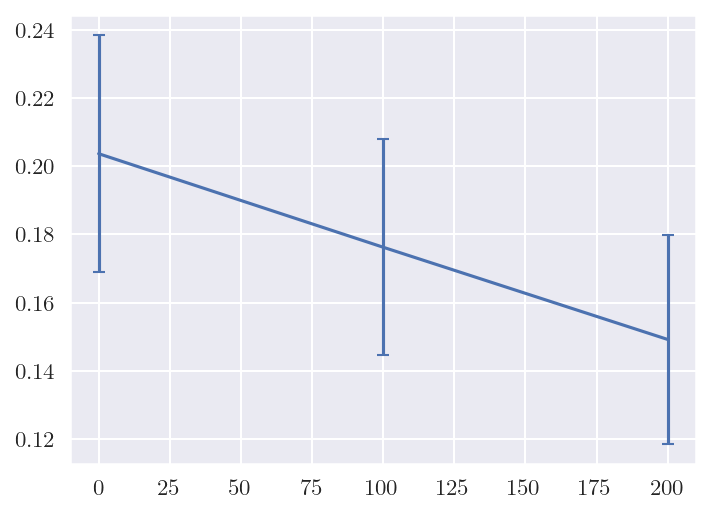

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from cmr.utils.plot import NEURIPS_RCPARAMS, LINE_WIDTH

plt.rcParams.update(NEURIPS_RCPARAMS)
sns.set_theme()
figsize = (LINE_WIDTH/1.3, LINE_WIDTH / 1.8)

fig, ax = plt.subplots(1, 1, figsize=figsize)

n_refs = [0, 100, 200]
for divergence in ['kl']:
    mean = []
    std = []
    for n_ref in n_refs:
        m, s = get_mean_and_sem(kmm, test_metric='test_risk', val_metric='val_loss', hparam_config={'rkhs_func_z_dependent': 1.0,
                                       'val_loss_func': 'moment_violation',
                                       "n_reference_samples": n_ref, 
                                       "entropy_reg_param": [1],
                                       "reg_param": [1],
                                       'kde_bw': 0.1,
                                       'divergence': divergence})
        mean.append(m)
        std.append(s)
    ax.errorbar(n_refs, mean, std)
    

# EXP2: Network IV

## Load Data

In [12]:
# func = 'step'
# exp_path_2 = f"/Users/hkremer/code/kmm/wasserstein-method-of-moments/results/network_iv_{func}/network_iv_method="

# from cmr.default_config import vmm_methods

# filepaths = []
# for method in vmm_methods:
#     path = (exp_path_2 + f'{method}_n=2000_seed0=12345_{func}.json')
#     filepaths.append(path)
    
# vmm = load_and_merge_datasets(filepaths)



# from cmr.default_config import fgel_methods

# filepaths = []
# for method in fgel_methods:
#     path = (exp_path_2 + f'{method}_n=2000_seed0=12345_{func}.json')
#     filepaths.append(path)
    
# fgel = load_and_merge_datasets(filepaths)



# from cmr.default_config import kmm_methods

# filepaths = []
# for method in kmm_methods:
#     path = (exp_path_2 + f'{method}_n=2000_seed0=12345_{func}.json')
#     filepaths.append(path)

# kmm = load_and_merge_datasets(filepaths)


In [24]:
func = 'sin'

vmm = load_and_merge_datasets(load_all_in_dir=f'/Users/hkremer/code/kmm/wasserstein-method-of-moments/results/network_iv_{func}/',
                              method="VMM-neural")
    
    
fgel = load_and_merge_datasets(load_all_in_dir=f'/Users/hkremer/code/kmm/wasserstein-method-of-moments/results/network_iv_{func}/',
                              method="FGEL-neural")    
    
kmm = load_and_merge_datasets(load_all_in_dir=f'/Users/hkremer/code/kmm/wasserstein-method-of-moments/results/network_iv_{func}/',
                              method="KMM")

Found 9/9 files.
Found 28/28 files.
Found 931/931 files.


In [25]:
metric = 'val_loss'
val_loss_func = 'mmr'

## VMM

In [26]:
best_vmm = get_best_hparam_results(vmm, metric=metric, hparam_config={'val_loss_func': val_loss_func})
best_vmm

,test_risk,mse,val_loss,reg_param,version
config_id,,,,,
3,0.093102,0.0,0.000338,10.0000,3.0
2,0.067894,0.0,0.000748,0.0000,2.0
1,0.072424,0.0,0.000769,0.0001,1.0
5,0.076329,0.0,0.000887,0.0100,5.0


## FGEL

In [28]:
best_fgel = get_best_hparam_results(fgel, metric=metric, hparam_config={'val_loss_func': val_loss_func})
best_fgel

,test_risk,mse,val_loss,reg_param,version
config_id,,,,,
7,0.086142,0.0,0.000211,10.0000,7.0
27,0.080757,0.0,0.000224,10.0000,27.0
6,0.084106,0.0,0.000278,1.0000,6.0
15,0.076847,0.0,0.000370,1.0000,15.0
23,0.084392,0.0,0.000373,1.0000,23.0
4,0.088862,0.0,0.000501,0.0100,4.0
3,0.085827,0.0,0.000552,0.0000,3.0
16,0.093847,0.0,0.000567,0.0100,16.0
14,0.086342,0.0,0.000621,0.0001,14.0


## KMM

In [32]:
best_kmm = get_best_hparam_results(kmm, metric=metric, hparam_config={'val_loss_func': val_loss_func,
                                                                      'n_reference_samples': [400],
                                                                      "n_random_features": 10000,
                                                                      #"kde_bw": 1.0,
                                                                      #"batch_size": np.nan,
                                                                      #"reg_param": 1,
                                                                      #'entropy_reg_param': 1,
                                                                      "rkhs_reg_param": np.nan
                                                                     })
best_kmm

,test_risk,mse,val_loss,n_reference_samples,entropy_reg_param,reg_param,kde_bw,version,rkhs_reg_param
config_id,,,,,,,,,
494,0.071255,0.0,0.000178,400.0,1000.0,0.10,0.1,494.0,NaN
96,0.085020,0.0,0.000193,400.0,1000.0,10.00,0.1,96.0,NaN
213,0.085020,0.0,0.000193,400.0,1000.0,10.00,1.0,213.0,NaN
642,0.085340,0.0,0.000205,400.0,10.0,0.01,1.0,642.0,NaN
178,0.088056,0.0,0.000214,400.0,100.0,10.00,0.1,178.0,NaN
371,0.084318,0.0,0.000217,400.0,10.0,10.00,0.1,371.0,NaN
406,0.086809,0.0,0.000219,400.0,1.0,10.00,0.1,406.0,NaN
635,0.086809,0.0,0.000219,400.0,1.0,10.00,1.0,635.0,NaN
535,0.082857,0.0,0.000228,400.0,10.0,10.00,1.0,535.0,NaN


In [18]:
from tabulate import tabulate

def generate_table_network_iv(n_train, methods, val_loss_func='mmr', kmm_hparam_config={}):
    funcs = ['abs', 'step', 'sin']
    
    results = {func: {model: {} for model in methods} for func in funcs}
    for func in funcs:
        path = f"/Users/hkremer/code/kmm/wasserstein-method-of-moments/results/network_iv_{func}/"
        for method in methods:
            hparam_config = kmm_hparam_config if method == 'KMM' else {}
            if method in ['FGEL-neural', 'VMM-neural', 'KMM']:
                hparam_config['val_loss_func'] = val_loss_func
            df = load_and_merge_datasets(load_all_in_dir=path, method=method)
            mean, sem = get_mean_and_sem(df, test_metric='test_risk', val_metric='val_loss',
                                         hparam_config=hparam_config)

            results[func][method] = {'mean': mean, 'sem': sem}

    row1 = [''] + [model for model in methods]
    table = [row1]
    for func in funcs:
        table.append([f'{func}'] + [
            r"${:.2f}\pm{:.2f}$".format(results[func][model]["mean"] * 1e1, results[func][model]["sem"] * 1e1) for
            model in results[func].keys()])
    print(tabulate(table, tablefmt="latex_raw"))

In [19]:
methods = ['OLS', 'SMD', "MMR", 'DeepIV', 'VMM-neural', 'FGEL-neural', 'KMM']

hparam_config={'val_loss_func': val_loss_func,
              'n_reference_samples': [200],
              "n_random_features": 10000,
              "rkhs_reg_param": np.nan,}

generate_table_network_iv(n_train=None, methods=methods, val_loss_func='mmr', kmm_hparam_config=hparam_config)

Found 1/1 files.
0
Found 1/1 files.
0
Found 1/1 files.
0
Found 1/1 files.
0
Found 10/10 files.
9.0
Found 24/24 files.
19.0
Found 933/933 files.
666.0
Found 1/1 files.
0
Found 1/1 files.
0
Found 1/1 files.
0
Found 1/1 files.
0
Found 9/9 files.
2.0
Found 26/26 files.
12.0
Found 937/937 files.
216.0
Found 1/1 files.
0
Found 1/1 files.
0
Found 1/1 files.
0
Found 1/1 files.
0
Found 9/9 files.
3.0
Found 28/28 files.
7.0
Found 931/931 files.
435.0
\begin{tabular}{llllllll}
\hline
      & OLS           & SMD           & MMR           & DeepIV        & VMM-neural    & FGEL-neural   & KMM           \\
 abs  & $3.27\pm0.40$ & $1.37\pm1.23$ & $1.40\pm1.06$ & $2.60\pm1.49$ & $0.20\pm0.05$ & $0.18\pm0.05$ & $0.20\pm0.07$ \\
 step & $2.95\pm0.10$ & $0.25\pm0.03$ & $0.50\pm0.05$ & $0.66\pm0.06$ & $0.28\pm0.03$ & $0.25\pm0.02$ & $0.24\pm0.03$ \\
 sin  & $3.27\pm0.07$ & $1.28\pm0.11$ & $2.54\pm0.29$ & $3.62\pm0.27$ & $0.93\pm0.10$ & $0.86\pm0.10$ & $0.72\pm0.11$ \\
\hline
\end{tabular}


In [33]:
methods = ['OLS', 'SMD', "MMR", 'DeepIV', 'VMM-neural', 'FGEL-neural', 'KMM']

hparam_config={'val_loss_func': val_loss_func,
              'n_reference_samples': [200],
              "n_random_features": 10000,
              "rkhs_reg_param": np.nan,}

generate_table_network_iv(n_train=None, methods=methods, val_loss_func='moment_violation', kmm_hparam_config=hparam_config)

Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 10/10 files.
Found 24/24 files.
Found 933/933 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 9/9 files.
Found 26/26 files.
Found 937/937 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 9/9 files.
Found 28/28 files.
Found 931/931 files.
\begin{tabular}{llllllll}
\hline
      & OLS           & SMD           & MMR           & DeepIV        & VMM-neural    & FGEL-neural   & KMM           \\
 abs  & $3.27\pm0.40$ & $1.37\pm1.23$ & $1.40\pm1.06$ & $2.60\pm1.49$ & $0.17\pm0.04$ & $0.18\pm0.04$ & $0.15\pm0.02$ \\
 step & $2.95\pm0.10$ & $0.25\pm0.03$ & $0.50\pm0.05$ & $0.66\pm0.06$ & $0.26\pm0.06$ & $0.28\pm0.02$ & $0.26\pm0.02$ \\
 sin  & $3.27\pm0.07$ & $1.28\pm0.11$ & $2.54\pm0.29$ & $3.62\pm0.27$ & $0.86\pm0.08$ & $0.86\pm0.09$ & $0.89\pm0.09$ \\
\hline
\end{tabular}


In [34]:
methods = ['OLS', 'SMD', "MMR", 'DeepIV', 'VMM-neural', 'FGEL-neural', 'KMM']

hparam_config={'val_loss_func': val_loss_func,
              'n_reference_samples': [400],
              "n_random_features": 10000,
              "rkhs_reg_param": np.nan,}

generate_table_network_iv(n_train=None, methods=methods, val_loss_func='moment_violation', kmm_hparam_config=hparam_config)

Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 10/10 files.
Found 24/24 files.
Found 933/933 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 9/9 files.
Found 26/26 files.
Found 937/937 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 9/9 files.
Found 28/28 files.
Found 931/931 files.
\begin{tabular}{llllllll}
\hline
      & OLS           & SMD           & MMR           & DeepIV        & VMM-neural    & FGEL-neural   & KMM           \\
 abs  & $3.27\pm0.40$ & $1.37\pm1.23$ & $1.40\pm1.06$ & $2.60\pm1.49$ & $0.17\pm0.04$ & $0.18\pm0.04$ & $0.16\pm0.02$ \\
 step & $2.95\pm0.10$ & $0.25\pm0.03$ & $0.50\pm0.05$ & $0.66\pm0.06$ & $0.26\pm0.06$ & $0.28\pm0.02$ & $0.27\pm0.02$ \\
 sin  & $3.27\pm0.07$ & $1.28\pm0.11$ & $2.54\pm0.29$ & $3.62\pm0.27$ & $0.86\pm0.08$ & $0.86\pm0.09$ & $0.83\pm0.08$ \\
\hline
\end{tabular}
